In [6]:
import os
import pandas as pd
import numpy as np

# Set project root to ml_project directory
if os.getcwd().endswith('src'):
    os.chdir('..')
    
project_root = os.getcwd()
print(f"Working directory: {project_root}")


Working directory: /Users/arthur/Documents/Universite/M2-QEA/Machine Learning/final_project/ml_project


In [7]:

# Load reference/lookup tables (used for both train and test)
job_desc_map_df = pd.read_csv("data/code_job_desc_map.csv")
departments_df = pd.read_csv("data/departments.csv")
sports_desc_df = pd.read_csv("data/code_Sports.csv")
city_pop_df = pd.read_csv("data/city_pop.csv")
city_loc_df = pd.read_csv("data/city_loc.csv")
city_loc_df = city_loc_df.drop(columns=['LAT', 'Long'], errors='ignore')
city_adm_df = pd.read_csv("data/city_adm.csv")
city_aav_df = pd.read_excel("data/additional_data/AAV2020.xlsx", sheet_name='Composition_communale', skiprows=5)
city_aav_df = city_aav_df.drop(columns=['LIBGEO', 'LIBAAV2020', 'DEP', 'REG'], errors='ignore')


print(f"✓ Reference tables loaded")

✓ Reference tables loaded


In [10]:
def load_and_merge_datasets(dataset_type='learn'):
    """
    Load and merge all datasets for training or testing.
    
    Parameters:
    -----------
    dataset_type : str
        Either 'learn' or 'test'
    
    Returns:
    --------
    tuple: (merged_df, job_cols, retired_cols, pension_cols, sport_cols)
    """
    prefix = f"data/{dataset_type}_dataset"
    
    # Load all datasets
    print(f"\nLoading {dataset_type} datasets...")
    main_df = pd.read_csv(f"{prefix}.csv")
    sport_df = pd.read_csv(f"{prefix}_sport.csv")
    job_df = pd.read_csv(f"{prefix}_job.csv")
    job_security_df = pd.read_csv(f"{prefix}_JOB_SECURITY.csv")
    retired_former_df = pd.read_csv(f"{prefix}_retired_former.csv")
    retired_jobs_df = pd.read_csv(f"{prefix}_retired_jobs.csv")
    retired_pension_df = pd.read_csv(f"{prefix}_retired_pension.csv")
    
    print(f"✓ {dataset_type.capitalize()} datasets loaded: main{main_df.shape}, sport{sport_df.shape}, "
          f"job{job_df.shape}, retired_jobs{retired_jobs_df.shape}, retired_pension{retired_pension_df.shape}")
    
    # Merge with reference tables
    job_df = job_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
    retired_jobs_df = retired_jobs_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
    sport_df = sport_df.merge(sports_desc_df, left_on='Sports', right_on='Code', how='left')
    sport_df = sport_df[['primary_key', 'Sports', 'Categorie']]

    
    # Rename columns with meaningful suffixes
    job_df_renamed = job_df.rename(columns={col: f"{col}_current" for col in job_df.columns if col != 'primary_key'})
    retired_jobs_df_renamed = retired_jobs_df.rename(columns={col: f"{col}_retired" for col in retired_jobs_df.columns if col != 'primary_key'})
    
    # Merge all datasets
    df = main_df.merge(job_df_renamed, on='primary_key', how='left')
    df = df.merge(job_security_df, on='primary_key', how='left')
    df = df.merge(retired_jobs_df_renamed, on='primary_key', how='left')
    df = df.merge(retired_pension_df, on='primary_key', how='left')
    df = df.merge(retired_former_df, on='primary_key', how='left')
    df = df.merge(sport_df, on='primary_key', how='left')
    df = df.merge(city_loc_df, on='Insee_code', how='left')
    df = df.merge(city_adm_df, on='Insee_code', how='left')
    df = df.merge(city_aav_df, left_on='Insee_code', right_on='CODGEO', how='left')
    
    # Save column lists for imputers
    job_cols = [col for col in df.columns if col.endswith('_current')]
    retired_cols = [col for col in df.columns if col.endswith('_retired')]
    pension_cols = [col for col in retired_pension_df.columns if col != 'primary_key' and col in df.columns]
    sport_cols = [col for col in sport_df.columns if col != 'primary_key' and col in df.columns]
    
    print(f"✓ Merged {dataset_type} datasets: {df.shape}")
    print(f"  - Current job columns: {len(job_cols)} (suffix: _current)")
    print(f"  - Retired job columns: {len(retired_cols)} (suffix: _retired)")
    print(f"  - Pension columns: {len(pension_cols)}")
    print(f"  - Sport columns: {len(sport_cols)}")
    
    return df, job_cols, retired_cols, pension_cols, sport_cols


# Load and merge training data
learn_df, job_cols_in_df, retired_cols_in_df, pension_cols_in_df, sport_cols_in_df = load_and_merge_datasets('learn')
test_df, job_cols_in_df, retired_cols_in_df, pension_cols_in_df, sport_cols_in_df = load_and_merge_datasets('test')


Loading learn datasets...
✓ Learn datasets loaded: main(50044, 10), sport(6460, 2), job(19336, 11), retired_jobs(11226, 11), retired_pension(11226, 2)
✓ Merged learn datasets: (50044, 51)
  - Current job columns: 13 (suffix: _current)
  - Retired job columns: 13 (suffix: _retired)
  - Pension columns: 1
  - Sport columns: 2

Loading test datasets...
✓ Test datasets loaded: main(50042, 9), sport(6405, 2), job(19277, 11), retired_jobs(11282, 11), retired_pension(11282, 2)
✓ Merged test datasets: (50042, 50)
  - Current job columns: 13 (suffix: _current)
  - Retired job columns: 13 (suffix: _retired)
  - Pension columns: 1
  - Sport columns: 2


MAP: TARGET DISTRIBUTION (Lambert 93 Projection)
Plotting 50,044 observations with valid coordinates


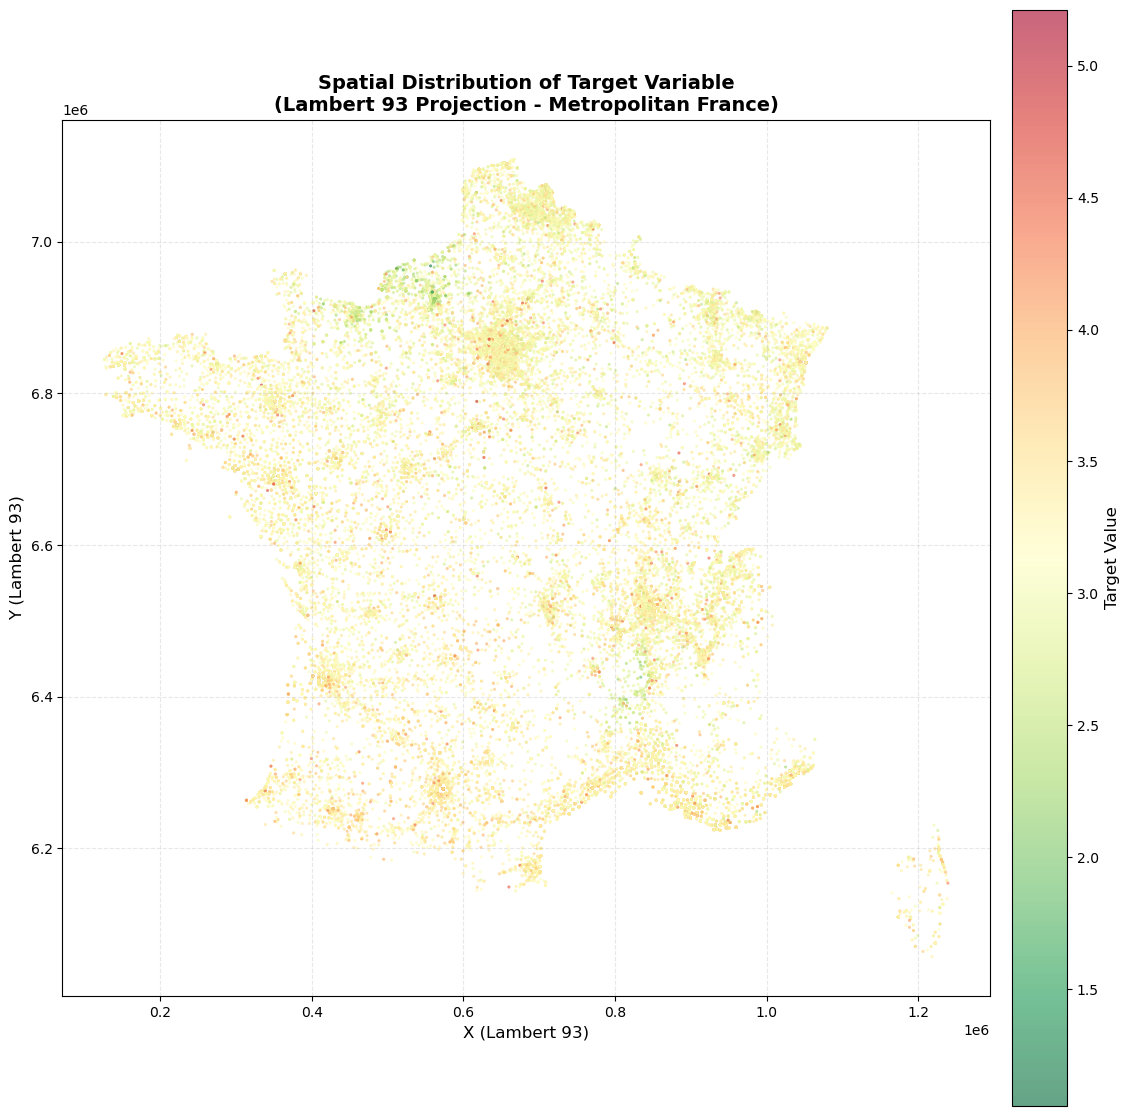


Target Statistics:
  Mean: 3.22
  Median: 3.19
  Min: 1.06
  Max: 5.21


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create a map visualization of target using X, Y coordinates (Lambert 93)
print("=" * 60)
print("MAP: TARGET DISTRIBUTION (Lambert 93 Projection)")
print("=" * 60)

# Check if required columns exist
required_cols = ['X', 'Y', 'target']
missing_cols = [col for col in required_cols if col not in learn_df.columns]

if missing_cols:
    print(f"⚠️ Missing columns: {missing_cols}")
else:
    # Filter out rows with missing coordinates or target
    map_data = learn_df[['X', 'Y', 'target']].dropna()
    print(f"Plotting {len(map_data):,} observations with valid coordinates")
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 14))
    
    # Create scatter plot with target as color
    scatter = ax.scatter(
        map_data['X'], 
        map_data['Y'], 
        c=map_data['target'], 
        cmap='RdYlGn_r',  # Red = high values, Green = low values
        alpha=0.6,
        s=5,  # Small point size for dense data
        edgecolors='none'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Target Value', fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('X (Lambert 93)', fontsize=12)
    ax.set_ylabel('Y (Lambert 93)', fontsize=12)
    ax.set_title('Spatial Distribution of Target Variable\n(Lambert 93 Projection - Metropolitan France)', 
                 fontsize=14, fontweight='bold')
    
    # Equal aspect ratio for correct geographic representation
    ax.set_aspect('equal')
    
    # Add grid
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nTarget Statistics:")
    print(f"  Mean: {map_data['target'].mean():.2f}")
    print(f"  Median: {map_data['target'].median():.2f}")
    print(f"  Min: {map_data['target'].min():.2f}")
    print(f"  Max: {map_data['target'].max():.2f}")

MAP: TARGET DISTRIBUTION (Lambert 93 Projection)
Plotting 8,181 observations with valid coordinates (Paris AAV)


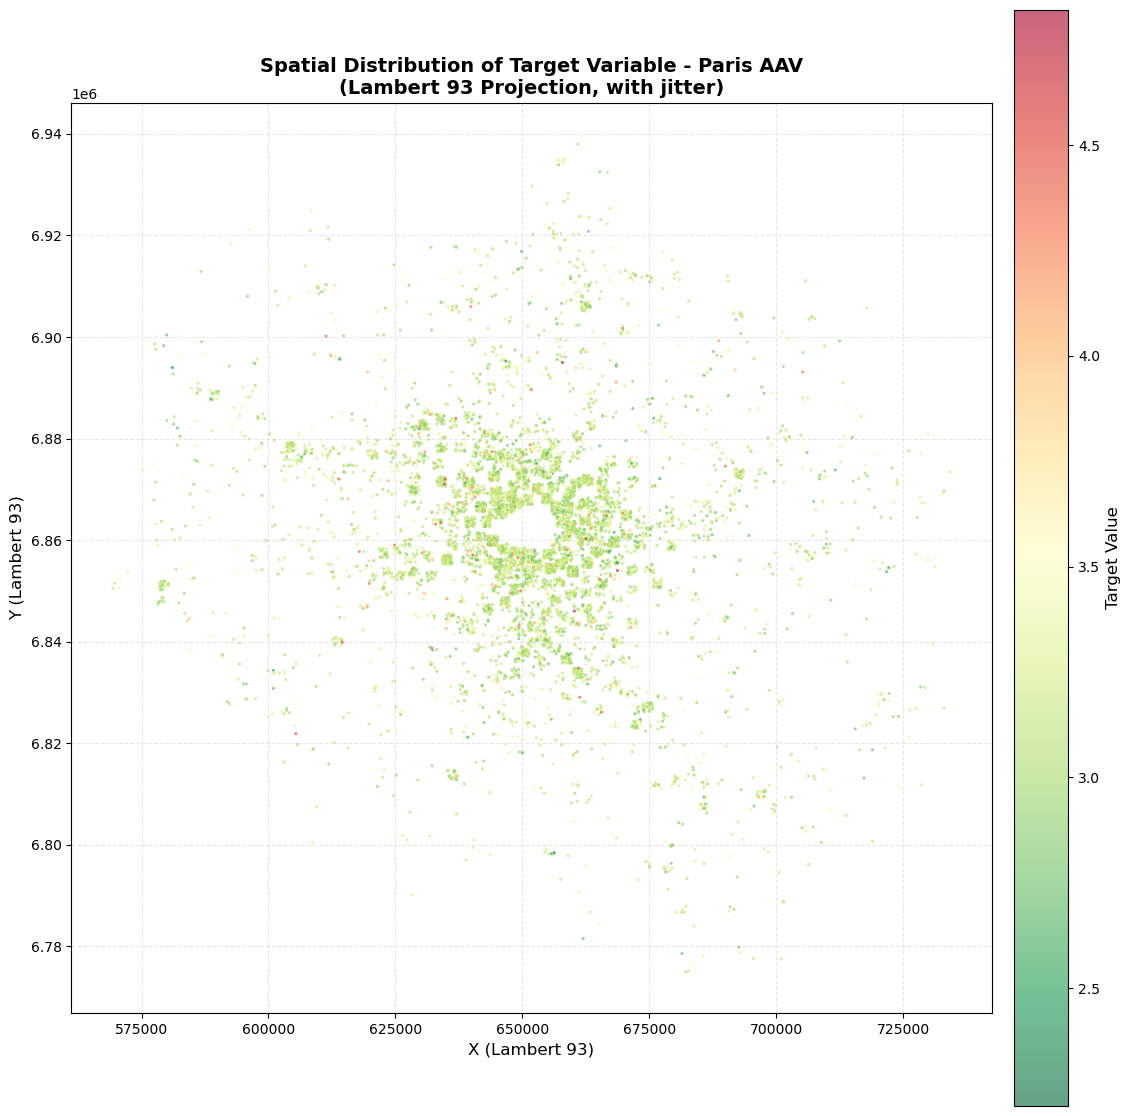


Target Statistics (Paris AAV):
  Mean: 3.19
  Median: 3.16
  Min: 2.22
  Max: 4.82


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create a map visualization of target using X, Y coordinates (Lambert 93)
print("=" * 60)
print("MAP: TARGET DISTRIBUTION (Lambert 93 Projection)")
print("=" * 60)

# Check if required columns exist
required_cols = ['X', 'Y', 'target']
missing_cols = [col for col in required_cols if col not in learn_df.columns]

if missing_cols:
    print(f"⚠️ Missing columns: {missing_cols}")
else:
    # Filter for Paris AAV (AAV2020 == '001' - string value)
    map_data = learn_df.loc[learn_df['AAV2020'] == '001', ['X', 'Y', 'target']].dropna()
    print(f"Plotting {len(map_data):,} observations with valid coordinates (Paris AAV)")
    
    # Add jitter to coordinates to reveal overlapping points
    jitter_scale = 1000  # Jitter in meters (Lambert 93 units)
    np.random.seed(42)  # For reproducibility
    x_jitter = map_data['X'] + np.random.uniform(-jitter_scale, jitter_scale, len(map_data))
    y_jitter = map_data['Y'] + np.random.uniform(-jitter_scale, jitter_scale, len(map_data))
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 14))
    
    # Create scatter plot with target as color
    scatter = ax.scatter(
        x_jitter, 
        y_jitter, 
        c=map_data['target'], 
        cmap='RdYlGn_r',  # Red = high values, Green = low values
        alpha=0.6,
        s=5,  # Small point size for dense data
        edgecolors='none'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Target Value', fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('X (Lambert 93)', fontsize=12)
    ax.set_ylabel('Y (Lambert 93)', fontsize=12)
    ax.set_title('Spatial Distribution of Target Variable - Paris AAV\n(Lambert 93 Projection, with jitter)', 
                 fontsize=14, fontweight='bold')
    
    # Equal aspect ratio for correct geographic representation
    ax.set_aspect('equal')
    
    # Add grid
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nTarget Statistics (Paris AAV):")
    print(f"  Mean: {map_data['target'].mean():.2f}")
    print(f"  Median: {map_data['target'].median():.2f}")
    print(f"  Min: {map_data['target'].min():.2f}")
    print(f"  Max: {map_data['target'].max():.2f}")

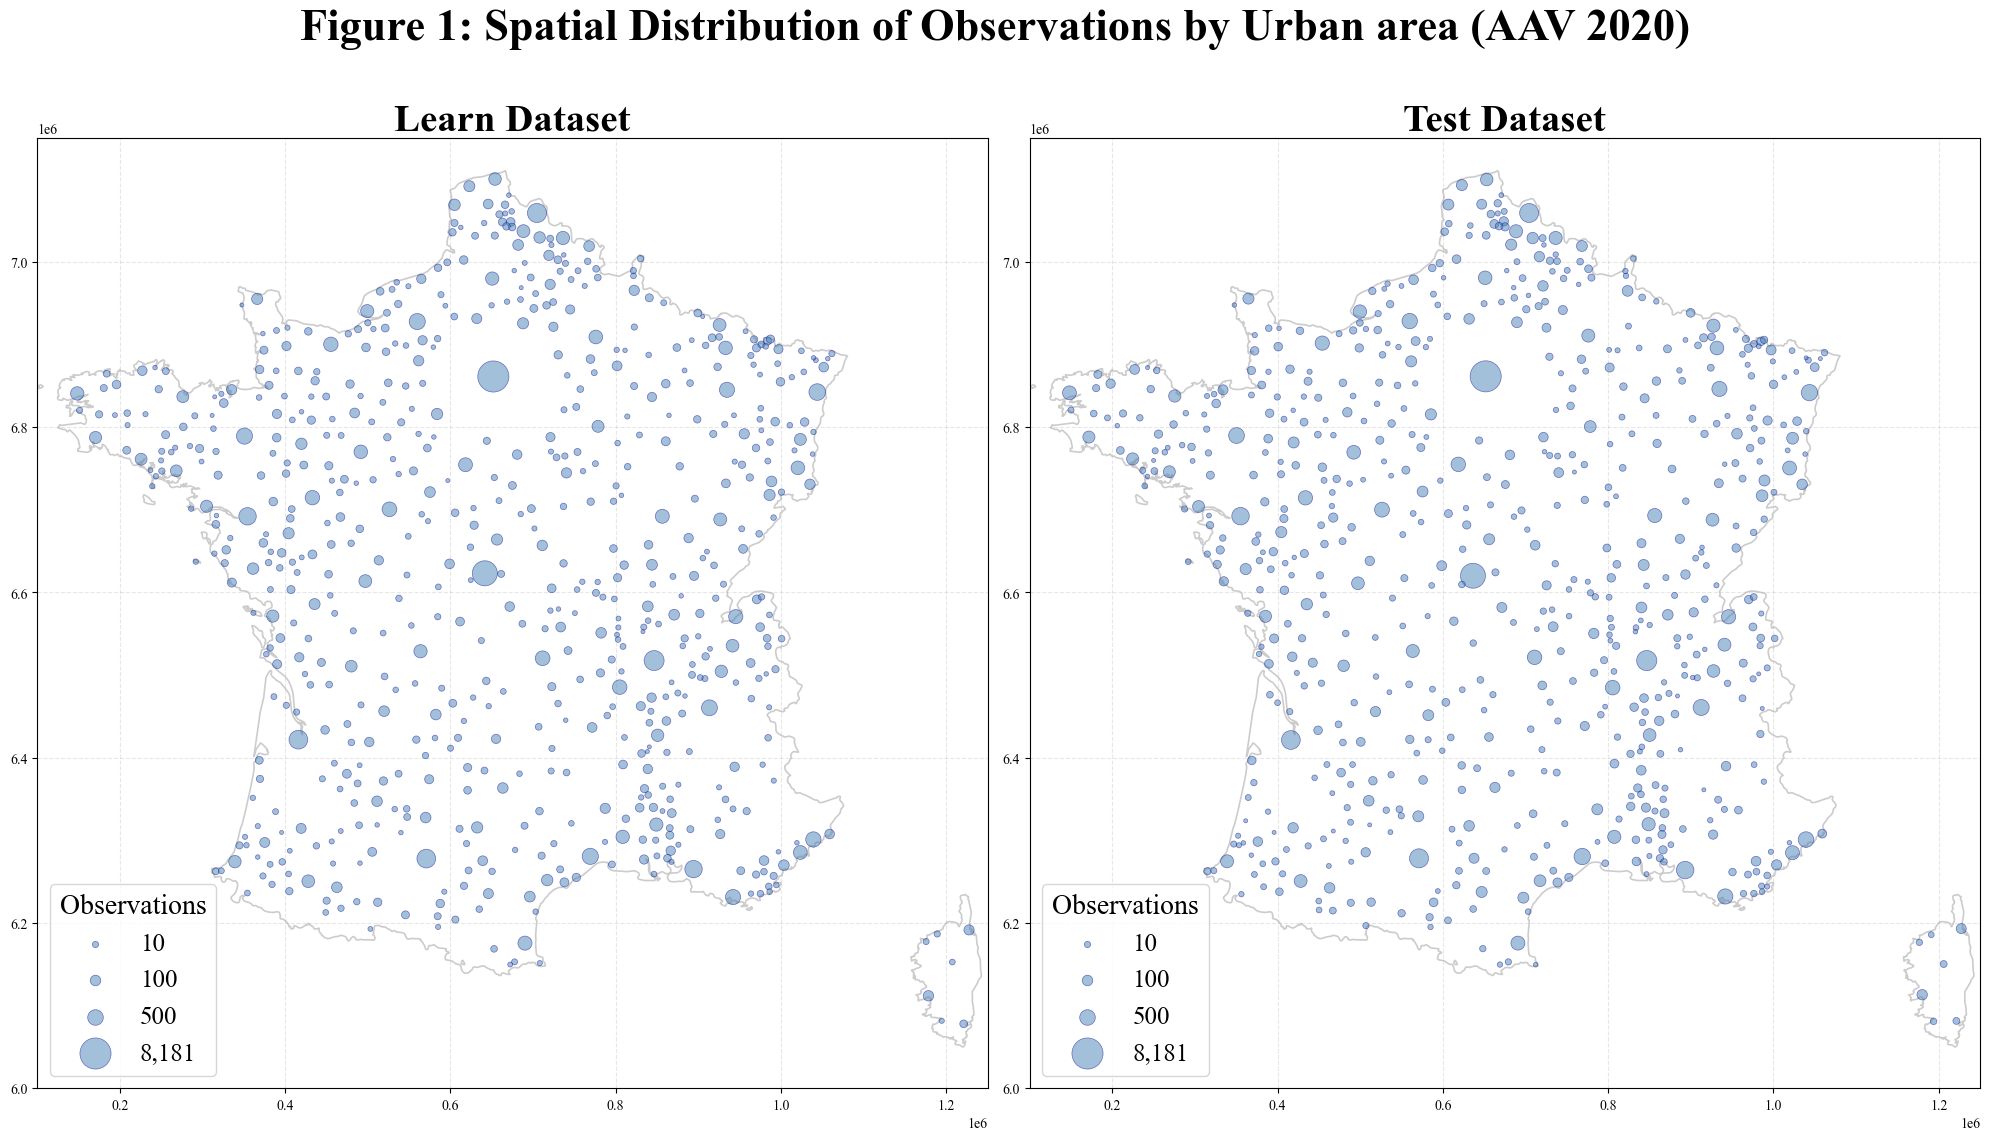


Metric                                     Learn         Test
------------------------------------------------------------
Total observations                        47,193       47,393
Unique AAV2020 zones                         676          678
Max observations per zone                  8,181        8,111


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# Set Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

def prepare_observation_map_data(df):
    """Prepare data for observation count map grouped by AAV2020."""
    map_df = df[['AAV2020', 'X', 'Y']].dropna().copy()
    return map_df.groupby('AAV2020').agg(
        n_obs=('AAV2020', 'count'),
        X_mean=('X', 'mean'),
        Y_mean=('Y', 'mean')
    ).reset_index()

# Load France borders
france_lambert = None
shapefile_path = "data/additional_data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
try:
    world = gpd.read_file(shapefile_path)
    france = world[world['ADMIN'] == 'France']
    france_lambert = france.to_crs(epsg=2154)
except:
    pass

# Prepare data
learn_map_data = prepare_observation_map_data(learn_df)
test_map_data = prepare_observation_map_data(test_df)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Compute bubble sizes with sqrt scaling
max_obs = max(learn_map_data['n_obs'].max(), test_map_data['n_obs'].max())
size_scale = 500

learn_sizes = np.sqrt(learn_map_data['n_obs'] / max_obs) * size_scale + 3
test_sizes = np.sqrt(test_map_data['n_obs'] / max_obs) * size_scale + 3

# Metropolitan France bounds in Lambert 93 (including Corsica and northern France)
france_xlim = (100000, 1250000)
france_ylim = (6000000, 7150000)

# Plot France borders on both maps
if france_lambert is not None:
    for ax in axes:
        france_lambert.boundary.plot(ax=ax, color='#cccccc', linewidth=1.2, zorder=1)

# Plot Learn Dataset
axes[0].scatter(
    learn_map_data['X_mean'], learn_map_data['Y_mean'],
    s=learn_sizes, alpha=0.5,
    color='steelblue', edgecolors='darkblue',
    linewidth=0.5, zorder=2
)

axes[0].set_title('Learn Dataset', fontsize=28, fontweight='bold')
axes[0].set_xlim(france_xlim)
axes[0].set_ylim(france_ylim)
axes[0].set_aspect('equal')
axes[0].grid(alpha=0.3, linestyle='--')

# Plot Test Dataset
axes[1].scatter(
    test_map_data['X_mean'], test_map_data['Y_mean'],
    s=test_sizes, alpha=0.5,
    color='steelblue', edgecolors='darkblue',
    linewidth=0.5, zorder=2
)

axes[1].set_title('Test Dataset', fontsize=28, fontweight='bold')
axes[1].set_xlim(france_xlim)
axes[1].set_ylim(france_ylim)
axes[1].set_aspect('equal')
axes[1].grid(alpha=0.3, linestyle='--')

# Add legend for bubble sizes
legend_sizes = [10, 100, 500, max_obs]
legend_bubbles = [np.sqrt(s / max_obs) * size_scale + 3 for s in legend_sizes]

for ax in axes:
    for size_val, bubble_size in zip(legend_sizes, legend_bubbles):
        ax.scatter([], [], s=bubble_size, c='steelblue', alpha=0.5, 
                   edgecolors='darkblue', linewidth=0.5, label=f'{size_val:,}')
    ax.legend(title='Observations', loc='lower left', fontsize=18, title_fontsize=20)

plt.suptitle('Figure 1: Spatial Distribution of Observations by Urban area (AAV 2020)', 
             fontsize=32, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'Metric':<35} {'Learn':>12} {'Test':>12}")
print("-" * 60)
print(f"{'Total observations':<35} {learn_map_data['n_obs'].sum():>12,} {test_map_data['n_obs'].sum():>12,}")
print(f"{'Unique AAV2020 zones':<35} {len(learn_map_data):>12,} {len(test_map_data):>12,}")
print(f"{'Max observations per zone':<35} {learn_map_data['n_obs'].max():>12,} {test_map_data['n_obs'].max():>12,}")

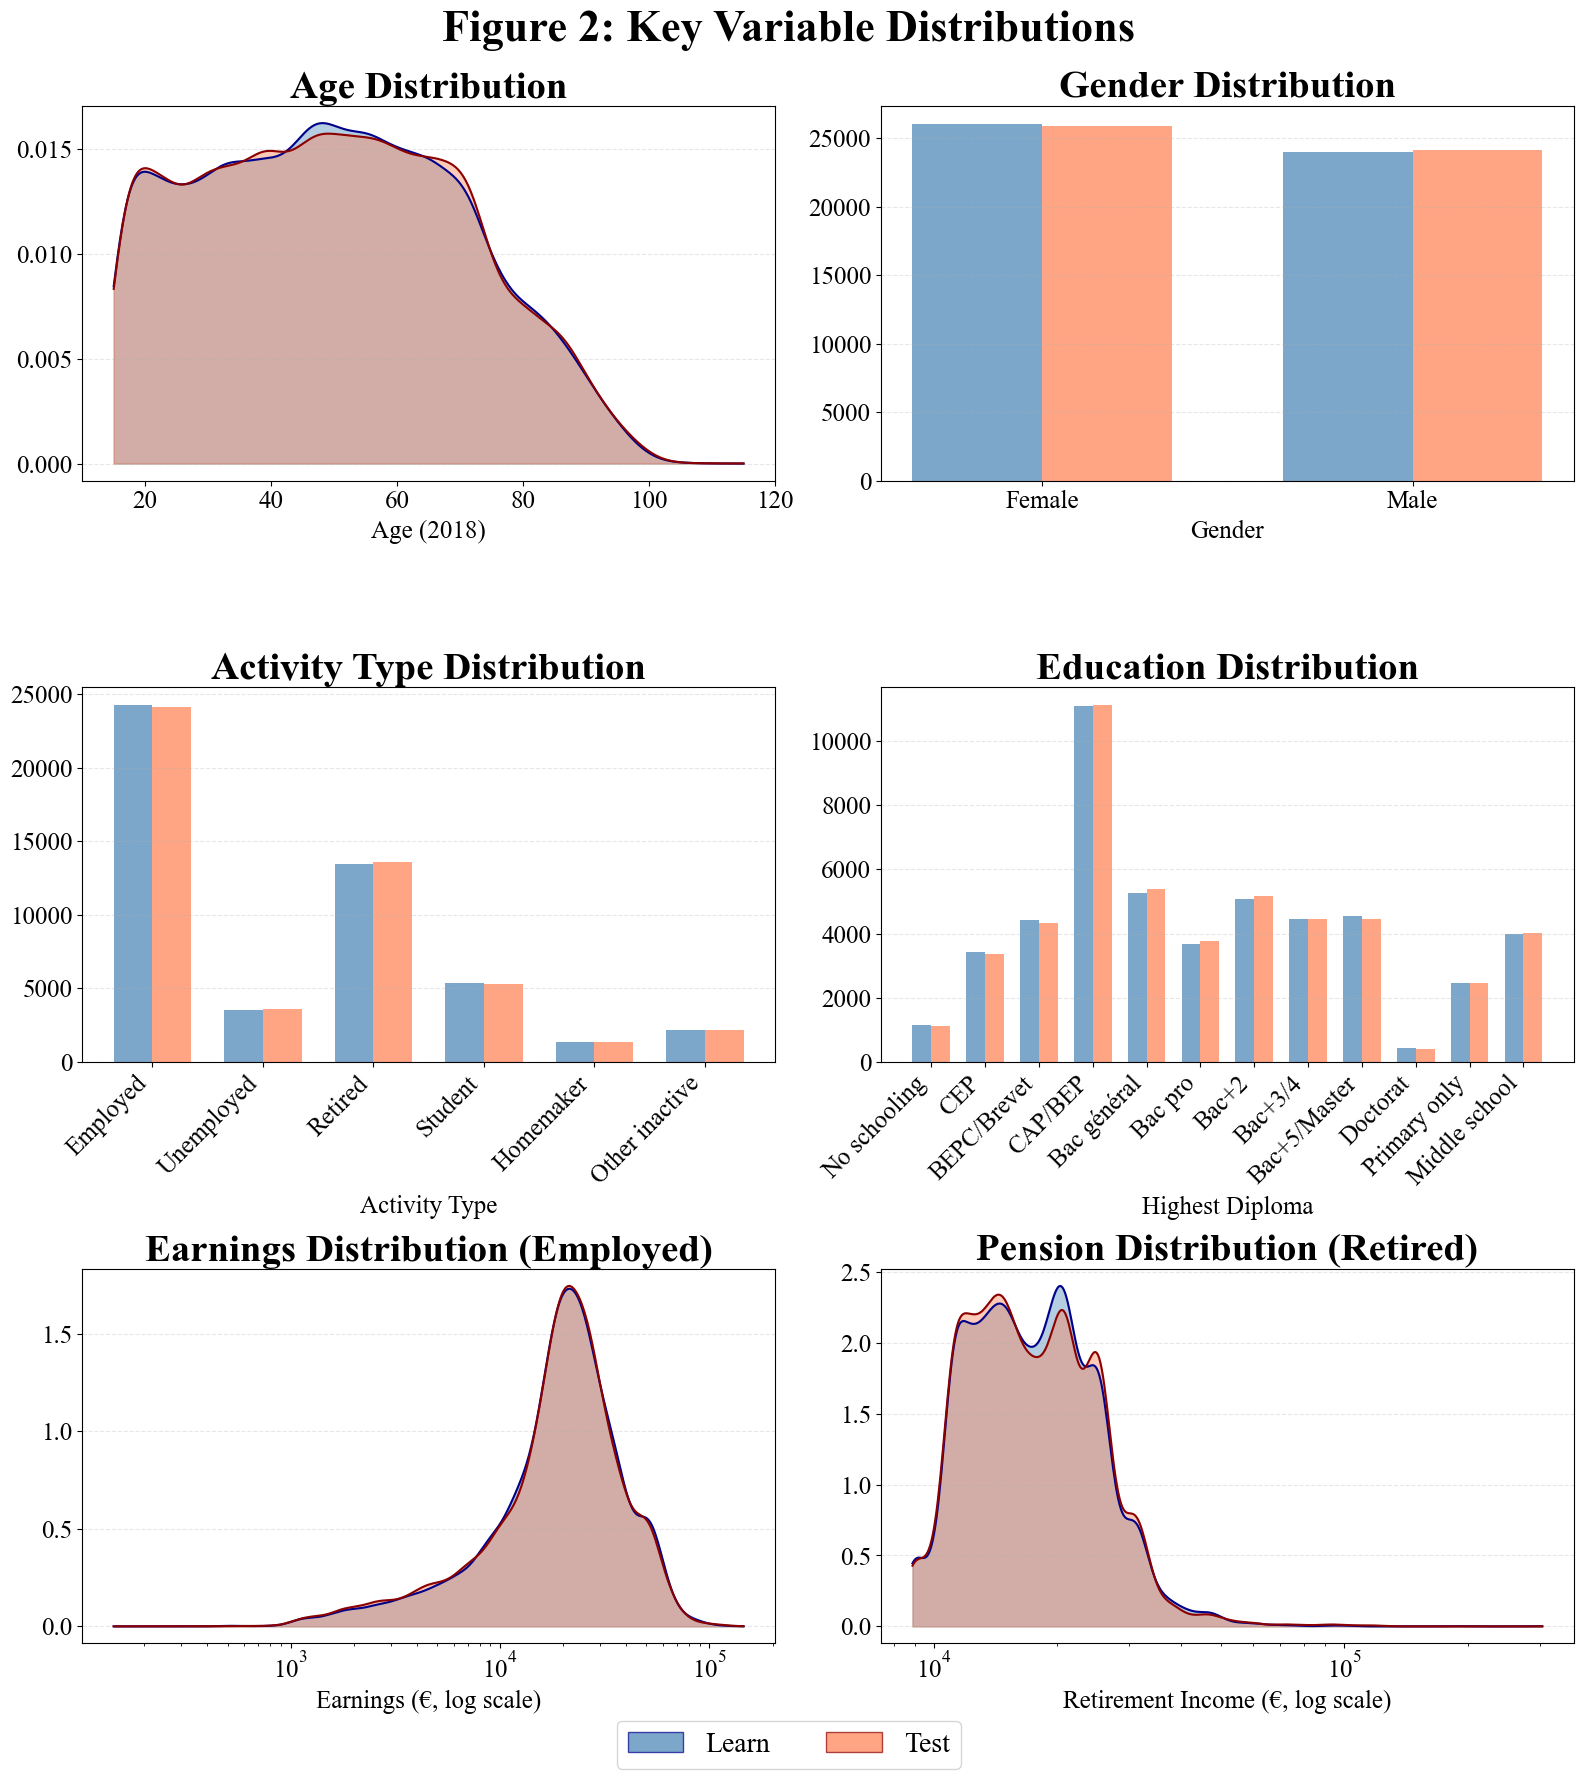


EARNINGS (Employed)                          
Statistic                   Learn         Test
---------------------------------------------
Count                      19,336       19,277
Mean                       22,772       22,561
Median                     20,484       20,394

RETIREMENT INCOME (Retired)                  
Statistic                   Learn         Test
---------------------------------------------
Count                      11,226       11,282
Mean                       18,640       18,674
Median                     17,164       16,992


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.patches import Patch

# Set Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# Load code tables for labels
activity_type_df = pd.read_csv("data/code_activity_type.csv")
diploma_df = pd.read_csv("data/code_HIGHEST_DIPLOMA.csv")

# Create mappings
activity_map = dict(zip(activity_type_df['Code'], activity_type_df['Libellé']))
diploma_map = dict(zip(diploma_df['Code'], diploma_df['Libellé']))

# Shorten labels for readability
activity_short = {
    'type1_1': 'Employed',
    'type1_2': 'Unemployed',
    'type2_1': 'Retired',
    'type2_2': 'Student',
    'type2_3': 'Under 14',
    'type2_4': 'Homemaker',
    'type2_5': 'Other inactive'
}

diploma_short = {
    'EDU1': 'No schooling',
    'EDU2': 'Primary only',
    'EDU3': 'Middle school',
    'EDU1.1': 'CEP',
    'EDU1.2': 'BEPC/Brevet',
    'EDU1.3': 'CAP/BEP',
    'EDU1.4': 'Bac général',
    'EDU1.5': 'Bac pro',
    'EDU1.6': 'Bac+2',
    'EDU1.7': 'Bac+3/4',
    'EDU1.8': 'Bac+5/Master',
    'EDU1.9': 'Doctorat'
}

sex_labels = {1: 'Male', 2: 'Female'}

# Create 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# === (0,0) Age Distribution - KDE ===
learn_age = learn_df['AGE_2018'].dropna()
test_age = test_df['AGE_2018'].dropna()
x_range = np.linspace(15, 115, 500)
learn_kde = stats.gaussian_kde(learn_age)
test_kde = stats.gaussian_kde(test_age)

axes[0, 0].fill_between(x_range, learn_kde(x_range), alpha=0.4, color='steelblue')
axes[0, 0].plot(x_range, learn_kde(x_range), color='darkblue', linewidth=1.5)
axes[0, 0].fill_between(x_range, test_kde(x_range), alpha=0.4, color='coral')
axes[0, 0].plot(x_range, test_kde(x_range), color='darkred', linewidth=1.5)
axes[0, 0].set_xlabel('Age (2018)', fontsize=18)
axes[0, 0].set_title('Age Distribution', fontsize=28, fontweight='bold')
axes[0, 0].tick_params(axis='both', labelsize=18)
axes[0, 0].grid(alpha=0.3, linestyle='--', axis='y')

# === (0,1) Gender Distribution - Bar ===
learn_sex = learn_df['sex'].value_counts().sort_index()
test_sex = test_df['sex'].value_counts().sort_index()
x = np.arange(len(learn_sex))
width = 0.35
labels = [sex_labels.get(i, str(i)) for i in learn_sex.index]

axes[0, 1].bar(x - width/2, learn_sex.values, width, color='steelblue', alpha=0.7)
axes[0, 1].bar(x + width/2, test_sex.values, width, color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Gender', fontsize=18)
axes[0, 1].set_title('Gender Distribution', fontsize=28, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(labels, fontsize=18)
axes[0, 1].tick_params(axis='both', labelsize=18)
axes[0, 1].grid(alpha=0.3, linestyle='--', axis='y')

# === (1,0) Activity Type Distribution - Bar ===
learn_activity = learn_df['activity_type'].value_counts().sort_index()
test_activity = test_df['activity_type'].value_counts().sort_index()
all_activities = sorted(set(learn_activity.index) | set(test_activity.index))
x = np.arange(len(all_activities))
width = 0.35
labels = [activity_short.get(a, a) for a in all_activities]

learn_vals = [learn_activity.get(a, 0) for a in all_activities]
test_vals = [test_activity.get(a, 0) for a in all_activities]

axes[1, 0].bar(x - width/2, learn_vals, width, color='steelblue', alpha=0.7)
axes[1, 0].bar(x + width/2, test_vals, width, color='coral', alpha=0.7)
axes[1, 0].set_xlabel('Activity Type', fontsize=18)
axes[1, 0].set_title('Activity Type Distribution', fontsize=28, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, rotation=45, ha='right', fontsize=18)
axes[1, 0].tick_params(axis='y', labelsize=18)
axes[1, 0].grid(alpha=0.3, linestyle='--', axis='y')

# === (1,1) Education Distribution - Bar ===
learn_edu = learn_df['HIGHEST_DIPLOMA'].value_counts().sort_index()
test_edu = test_df['HIGHEST_DIPLOMA'].value_counts().sort_index()
all_edu = sorted(set(learn_edu.index) | set(test_edu.index))
x = np.arange(len(all_edu))
width = 0.35
labels = [diploma_short.get(e, e) for e in all_edu]

learn_vals = [learn_edu.get(e, 0) for e in all_edu]
test_vals = [test_edu.get(e, 0) for e in all_edu]

axes[1, 1].bar(x - width/2, learn_vals, width, color='steelblue', alpha=0.7)
axes[1, 1].bar(x + width/2, test_vals, width, color='coral', alpha=0.7)
axes[1, 1].set_xlabel('Highest Diploma', fontsize=18)
axes[1, 1].set_title('Education Distribution', fontsize=28, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels, rotation=45, ha='right', fontsize=18)
axes[1, 1].tick_params(axis='y', labelsize=18)
axes[1, 1].grid(alpha=0.3, linestyle='--', axis='y')

# === (2,0) Earnings for Working People - KDE with log scale ===
# Filter for employed people (type1_1)
learn_workers = learn_df[learn_df['activity_type'] == 'type1_1']['Earnings_current'].dropna()
test_workers = test_df[test_df['activity_type'] == 'type1_1']['Earnings_current'].dropna()

# Use log-transformed data for KDE
learn_workers_log = np.log10(learn_workers[learn_workers > 0])
test_workers_log = np.log10(test_workers[test_workers > 0])

if len(learn_workers_log) > 0 and len(test_workers_log) > 0:
    x_log = np.linspace(
        min(learn_workers_log.min(), test_workers_log.min()),
        max(learn_workers_log.max(), test_workers_log.max()),
        500
    )
    learn_earn_kde = stats.gaussian_kde(learn_workers_log)
    test_earn_kde = stats.gaussian_kde(test_workers_log)
    
    x_earnings = 10 ** x_log  # Convert back to original scale for plotting
    
    axes[2, 0].fill_between(x_earnings, learn_earn_kde(x_log), alpha=0.4, color='steelblue')
    axes[2, 0].plot(x_earnings, learn_earn_kde(x_log), color='darkblue', linewidth=1.5)
    axes[2, 0].fill_between(x_earnings, test_earn_kde(x_log), alpha=0.4, color='coral')
    axes[2, 0].plot(x_earnings, test_earn_kde(x_log), color='darkred', linewidth=1.5)

axes[2, 0].set_xscale('log')
axes[2, 0].set_xlabel('Earnings (€, log scale)', fontsize=18)
axes[2, 0].set_title('Earnings Distribution (Employed)', fontsize=28, fontweight='bold')
axes[2, 0].tick_params(axis='both', labelsize=18)
axes[2, 0].grid(alpha=0.3, linestyle='--', axis='y')

# === (2,1) Retirement Income for Retirees - KDE with log scale ===
# Filter for retired people (type2_1)
learn_retired = learn_df[learn_df['activity_type'] == 'type2_1']['RETIREMENT_INCOME'].dropna()
test_retired = test_df[test_df['activity_type'] == 'type2_1']['RETIREMENT_INCOME'].dropna()

# Use log-transformed data for KDE
learn_retired_log = np.log10(learn_retired[learn_retired > 0])
test_retired_log = np.log10(test_retired[test_retired > 0])

if len(learn_retired_log) > 0 and len(test_retired_log) > 0:
    x_log = np.linspace(
        min(learn_retired_log.min(), test_retired_log.min()),
        max(learn_retired_log.max(), test_retired_log.max()),
        500
    )
    learn_pension_kde = stats.gaussian_kde(learn_retired_log)
    test_pension_kde = stats.gaussian_kde(test_retired_log)
    
    x_pension = 10 ** x_log  # Convert back to original scale for plotting
    
    axes[2, 1].fill_between(x_pension, learn_pension_kde(x_log), alpha=0.4, color='steelblue')
    axes[2, 1].plot(x_pension, learn_pension_kde(x_log), color='darkblue', linewidth=1.5)
    axes[2, 1].fill_between(x_pension, test_pension_kde(x_log), alpha=0.4, color='coral')
    axes[2, 1].plot(x_pension, test_pension_kde(x_log), color='darkred', linewidth=1.5)

axes[2, 1].set_xscale('log')
axes[2, 1].set_xlabel('Retirement Income (€, log scale)', fontsize=18)
axes[2, 1].set_title('Pension Distribution (Retired)', fontsize=28, fontweight='bold')
axes[2, 1].tick_params(axis='both', labelsize=18)
axes[2, 1].grid(alpha=0.3, linestyle='--', axis='y')

# Add general legend at the bottom
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, edgecolor='darkblue', label='Learn'),
    Patch(facecolor='coral', alpha=0.7, edgecolor='darkred', label='Test')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=20, 
           frameon=True, bbox_to_anchor=(0.5, 0.01))

plt.suptitle('Figure 2: Key Variable Distributions', fontsize=32, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.04, 1, 1])  # Leave space at bottom for legend and top for title
plt.show()

# Print summary stats for earnings and pensions
print(f"\n{'EARNINGS (Employed)':<45}")
print(f"{'Statistic':<20} {'Learn':>12} {'Test':>12}")
print("-" * 45)
print(f"{'Count':<20} {len(learn_workers):>12,} {len(test_workers):>12,}")
print(f"{'Mean':<20} {learn_workers.mean():>12,.0f} {test_workers.mean():>12,.0f}")
print(f"{'Median':<20} {learn_workers.median():>12,.0f} {test_workers.median():>12,.0f}")

print(f"\n{'RETIREMENT INCOME (Retired)':<45}")
print(f"{'Statistic':<20} {'Learn':>12} {'Test':>12}")
print("-" * 45)
print(f"{'Count':<20} {len(learn_retired):>12,} {len(test_retired):>12,}")
print(f"{'Mean':<20} {learn_retired.mean():>12,.0f} {test_retired.mean():>12,.0f}")
print(f"{'Median':<20} {learn_retired.median():>12,.0f} {test_retired.median():>12,.0f}")